# Medical Image Segmentation on CVC-ClinicDB dataset with FCN model

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import Compose, ToTensor, Normalize
from torchvision.datasets import ImageFolder
import torchvision.models as models
import numpy as np
from PIL import Image
from sklearn.metrics import accuracy_score
import os
import random
from torch.utils.data import Dataset, DataLoader


c:\users\ravis\appdata\local\programs\python\python38\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Data Preparation
Preprocessing the CVC-ClinicDB dataset by resizing the images and annotations to the appropriate input size of the models.

In [ ]:

# Define the paths for the dataset and the output directory
dataset_dir = '../../data/CVC-ClinicDB/PNG/'
output_dir = 'prepared_dataset\PolypDetection'

# Create directories for the training and validation sets
os.makedirs(os.path.join(output_dir, 'train'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'val'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'train',"images"), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'val',"images"), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'train',"masks"), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'val',"masks"), exist_ok=True)

# Define the ratio of samples to use for training vs. validation
train_val_ratio = 0.8

# Loop through each image file in the dataset directory
for filename in os.listdir(os.path.join(dataset_dir, 'Original')):
    if not filename.endswith('.png'):
        continue

    # Load the image and corresponding segmentation mask
    image = Image.open(os.path.join(dataset_dir, 'Original', filename))
    mask = Image.open(os.path.join(dataset_dir, 'Ground Truth', filename))

    # Convert the mask to a binary mask
    mask = mask.convert('1')

    # Split the sample into the training or validation set
    if random.random() < train_val_ratio:
        output_path = os.path.join(output_dir, 'train')
    else:
        output_path = os.path.join(output_dir, 'val')

    # Save the image and mask to the appropriate directory
    image.save(os.path.join(output_path, 'images', filename))
    mask.save(os.path.join(output_path, 'masks', filename))

# Create a text file containing the paths to the image and mask files for each sample
with open(os.path.join(output_dir, 'train.txt'), 'w') as f:
    for filename in os.listdir(os.path.join(output_dir, 'train', 'images')):
        if not filename.endswith('.png'):
            continue
        f.write(os.path.join(output_dir, 'train', 'images', filename) + ' ' +
                os.path.join(output_dir, 'train', 'masks', filename) + '\n')

with open(os.path.join(output_dir, 'val.txt'), 'w') as f:
    for filename in os.listdir(os.path.join(output_dir, 'val', 'images')):
        if not filename.endswith('.png'):
            continue
        f.write(os.path.join(output_dir, 'val', 'images', filename) + ' ' +
                os.path.join(output_dir, 'val', 'masks', filename) + '\n')

## Metrics to Evaluate Image Segmentation Model:
### Pixel accuracy:
Pixel accuracy measures the percentage of correctly classified pixels in the segmentation mask. It is calculated as the ratio of the number of pixels correctly classified to the total number of pixels in the image. Pixel accuracy is a simple and intuitive metric, but it may not be suitable for imbalanced datasets where the majority of pixels belong to the background class.
### Intersection-over-union (IoU):
Intersection-over-union (IoU), also known as Jaccard index, measures the overlap between the predicted and ground-truth segmentation masks. It is calculated as the ratio of the area of intersection between the two masks to the area of union. IoU ranges from 0 to 1, where 1 indicates a perfect overlap and 0 indicates no overlap. IoU is a popular metric for evaluating segmentation accuracy, especially for imbalanced datasets.

![image](images/IoU.png)

### Dice coefficient:
Dice coefficient, also known as F1 score, is another metric that measures the similarity between the predicted and ground-truth segmentation masks. It is calculated as twice the product of the number of true positive pixels and the number of total pixels in the two masks, divided by the sum of the number of true positive pixels, false positive pixels, and false negative pixels. Like IoU, Dice coefficient ranges from 0 to 1, with 1 indicating a perfect match and 0 indicating no match. Dice coefficient is a commonly used metric for evaluating segmentation accuracy, especially in medical imaging applications.

![image2](images/Dicecoefficient.png)


In [3]:
def pixel_accuracy(preds, targets):
    """
    Computes pixel accuracy between predicted and target segmentation masks.
    """
    #print(targets.view(-1))
    #print(preds.view(-1))
    return accuracy_score(targets.view(-1), preds.view(-1))

def intersection_over_union(preds, targets):
    """
    Computes intersection-over-union (Jaccard Index) between predicted and target segmentation masks.
    """
    #preds = preds.argmax(dim=1)
    intersection = torch.sum(targets * preds)
    union = torch.sum(targets) + torch.sum(preds) - intersection
    iou = intersection / union
    return iou.item()

def dice_coefficient(preds, targets):
    """
    Computes Dice coefficient (F1 score) between predicted and target segmentation masks.
    """
    #preds = preds.argmax(dim=1)
    intersection = torch.sum(targets * preds)
    dice = (2 * intersection) / (torch.sum(targets) + torch.sum(preds))
    return dice.item()

In [4]:
def calculate_metrices(model1,val_file_path,pretrained=True):
    # Define the transforms for the input images
    transform2tensor = Compose([
        ToTensor()])
    transform = Compose([
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Load the test image and mask
    
    with open(val_file_path,"r") as file:
        content=file.read()
    pa=0
    iou=0
    dice=0
    count=0
    for line in content.split("\n"):
        if len(line)>0:
            img_path,mask_path=line.split(" ")
            img = Image.open(img_path)
            mask = Image.open(mask_path)
            # Apply the transforms to the input image and mask
            img_tensor = transform(img).unsqueeze(0)
            mask_tensor=transform2tensor(mask)
            img_tensor=img_tensor.to(device)
            #mask_tensor=mask_tensor.to(device)
            with torch.no_grad():
                logits = model1(img_tensor)
                if pretrained:
                    output=logits["out"][0]
                    preds=preds.unsqueeze(0).cpu()
                    preds = output.argmax(0) 
                else:
                    output=logits
                    #print("output",output.shape)
                    #output=output.unsqueeze(0).cpu()
                    output=output[0]
                    preds = output.argmax(0) 
                    preds=preds.cpu()
                    # break
            #print(preds.shape,mask_tensor.shape)
            # Compute the evaluation metrics
            pa += pixel_accuracy(preds, mask_tensor)
            iou += intersection_over_union(preds, mask_tensor)
            dice += dice_coefficient(preds, mask_tensor)
            count+=1
    avg_pa=(pa/count)*100.
    avg_iou=(iou/count)*100
    avg_dice=(dice/count)*100
    return avg_pa,avg_iou,avg_dice



## Computing the metrices on Pretrained FCN Model

In [23]:
fcn_model = models.segmentation.fcn_resnet101(pretrained=True)
fcn_model.to(device)
val_file_path="prepared_dataset/PolypDetection/val.txt"
avg_pa,avg_iou,avg_dice=calculate_metrices(fcn_model,val_file_path)
print(f'Avg Pixel Accuracy: {avg_pa:.4f}')
print(f'Avg Intersection-over-Union: {avg_iou:.4f}')
print(f'Avg Dice Coefficient: {avg_dice:.4f}')

Avg Pixel Accuracy: 83.0500
Avg Intersection-over-Union: 51.3325
Avg Dice Coefficient: 47.7638


In [5]:
#preprocessing
transform = Compose([
            ToTensor(),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

## Fully convolutional network (FCN) 
Fully Convolutional Networks (FCNs) are a type of neural network architecture that is used for image segmentation tasks. Unlike traditional Convolutional Neural Networks (CNNs), which are designed for image classification tasks, FCNs produce dense pixel-wise predictions by mapping input images to output maps of the same size. This makes FCNs well-suited for applications such as semantic segmentation, where the goal is to assign a class label to each pixel in an image. In this report, we will provide an overview of the FCN methodology, discuss its advantages and limitations, and present some of the recent developments in this field.

### Methodology:
FCNs are designed by replacing the fully connected layers in traditional CNNs with convolutional layers. This is achieved by converting the fully connected layers into 1x1 convolutional layers, which preserve the spatial dimensions of the input. Additionally, FCNs use upsampling layers to increase the resolution of the output maps, which allows them to produce predictions that are the same size as the input image.

One of the most popular FCN architectures is the U-Net, which is an encoder-decoder architecture that was originally proposed for biomedical image segmentation tasks. The encoder compresses the input image into a lower-dimensional representation, while the decoder upsamples the representation to produce the output map. The U-Net also includes skip connections that connect the encoder and decoder at different levels, which helps to preserve spatial information and improve segmentation accuracy.

![image](images/FCN.png)


In [6]:
# Define the FCN model for transfer learning
class FCNTransfer(nn.Module):
    def __init__(self, num_classes,device="cpu",pretrained=True):
        super(FCNTransfer, self).__init__()
        # Load the pre-trained FCN model
        self.fcn = models.segmentation.fcn_resnet101(pretrained=pretrained)
        self.fcn.to(device)
        # Replace the final convolutional layer to output desired number of classes
        self.fcn.classifier[4] = nn.Conv2d(512, num_classes, kernel_size=(1,1))

    def forward(self, x):
        # Pass the input through the FCN model
        x = self.fcn(x)['out']
        # Upsample the output to the original image size
        x = nn.functional.interpolate(x, scale_factor=1, mode='bilinear', align_corners=False)
        return x



## Data reading Preprocessing

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, file_path,num_classes=2):
        self.file_path = file_path
        with open(file_path, 'r') as f:
            self.samples = f.readlines()
        self.num_classes=num_classes

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        line = self.samples[idx].split()
        img_path = line[0]
        mask_path = line[1]
        img = Image.open(img_path)
        mask = Image.open(mask_path)
        transform = Compose([
            ToTensor(),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        transform2tensor = Compose([
        ToTensor()])
        img = transform(img)
        mask = transform2tensor(mask)
        label_map = torch.zeros((self.num_classes, mask.size(1), mask.size(2)))
        # Apply the label encoding process to convert the grayscale image to a segmented image
        for i in range(self.num_classes):
            label_map[ i, :, :] = (mask == i).float()
        
        mask=label_map
        return img, mask
dataset_folder="prepared_dataset/PolypDetection"
train_dataset = ImageDataset(os.path.join(dataset_folder,'train.txt'),2)
val_dataset = ImageDataset(os.path.join(dataset_folder,'val.txt'),2)

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False)

## Initializing FCN model for Transfer learning

In [8]:
# Initialize the model and optimizer
model = FCNTransfer(num_classes=2,device=device)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)


c:\users\ravis\appdata\local\programs\python\python38\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\users\ravis\appdata\local\programs\python\python38\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=FCN_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Training The model

In [9]:
# Fine-tune the model
loss_list=[]
for epoch in range(10):
    for batch_idx, (data, target) in enumerate(train_dataloader):
        data=data.to(device)
        target=target.to(device)
        optimizer.zero_grad()
        output = model(data)
        #print(output.shape,output)
        #print(target.shape)
        loss = nn.functional.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_dataloader.dataset),
                100. * batch_idx / len(train_dataloader), loss.item()))
    loss_list.append(loss.item())

Train Epoch: 0 [0/486 (0%)]	Loss: 0.760607
Train Epoch: 0 [40/486 (8%)]	Loss: 0.468033
Train Epoch: 0 [80/486 (16%)]	Loss: 0.264415
Train Epoch: 0 [120/486 (25%)]	Loss: 0.252370
Train Epoch: 0 [160/486 (33%)]	Loss: 0.176644
Train Epoch: 0 [200/486 (41%)]	Loss: 0.187416
Train Epoch: 0 [240/486 (49%)]	Loss: 0.164326
Train Epoch: 0 [280/486 (57%)]	Loss: 0.152435
Train Epoch: 0 [320/486 (66%)]	Loss: 0.217159
Train Epoch: 0 [360/486 (74%)]	Loss: 0.126080
Train Epoch: 0 [400/486 (82%)]	Loss: 0.117058
Train Epoch: 0 [440/486 (90%)]	Loss: 0.122110
Train Epoch: 0 [480/486 (98%)]	Loss: 0.094128
Train Epoch: 1 [0/486 (0%)]	Loss: 0.093216
Train Epoch: 1 [40/486 (8%)]	Loss: 0.105733
Train Epoch: 1 [80/486 (16%)]	Loss: 0.085836
Train Epoch: 1 [120/486 (25%)]	Loss: 0.071484
Train Epoch: 1 [160/486 (33%)]	Loss: 0.064398
Train Epoch: 1 [200/486 (41%)]	Loss: 0.080256
Train Epoch: 1 [240/486 (49%)]	Loss: 0.080065
Train Epoch: 1 [280/486 (57%)]	Loss: 0.076178
Train Epoch: 1 [320/486 (66%)]	Loss: 0.060466


## Computing the metrices of Fine tuned pretrained FCN Model

In [12]:
val_file_path="prepared_dataset/PolypDetection/val.txt"
avg_pa,avg_iou,avg_dice=calculate_metrices(model,val_file_path,False)
print(f'Avg Pixel Accuracy: {avg_pa:.4f}')
print(f'Avg Intersection-over-Union: {avg_iou:.4f}')
print(f'Avg Dice Coefficient: {avg_dice:.4f}')


Avg Pixel Accuracy: 98.4464
Avg Intersection-over-Union: 83.0318
Avg Dice Coefficient: 89.1641


## Visualizing the output of the FCN Model

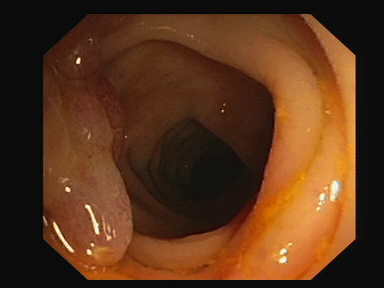

In [24]:
img = Image.open("prepared_dataset/PolypDetection/val/images/10.png")
img

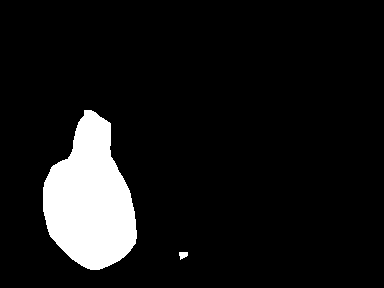

In [25]:
img_tensor = transform(img).unsqueeze(0)
img_tensor=img_tensor.to(device)
with torch.no_grad():
    logits = model(img_tensor)
    output=logits
    #print("output",output.shape)
    #output=output.unsqueeze(0).cpu()
    output=output[0]
    preds = output.argmax(0) 
Image.fromarray(preds.byte().cpu().numpy()*255).resize(img.size)

## Initialize the FCN model without pretraining

In [16]:
# Initialize the model and optimizer
model = FCNTransfer(num_classes=2,device=device,pretrained=False)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

c:\users\ravis\appdata\local\programs\python\python38\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


## Training of the FCN model without pretraining

In [17]:
# Fine-tune the model
loss_list=[]
for epoch in range(10):
    for batch_idx, (data, target) in enumerate(train_dataloader):
        data=data.to(device)
        target=target.to(device)
        optimizer.zero_grad()
        output = model(data)
        #print(output.shape,output)
        #print(target.shape)
        loss = nn.functional.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_dataloader.dataset),
                100. * batch_idx / len(train_dataloader), loss.item()))
    loss_list.append(loss.item())

Train Epoch: 0 [0/486 (0%)]	Loss: 1.269206
Train Epoch: 0 [40/486 (8%)]	Loss: 0.752706
Train Epoch: 0 [80/486 (16%)]	Loss: 0.305128
Train Epoch: 0 [120/486 (25%)]	Loss: 0.188695
Train Epoch: 0 [160/486 (33%)]	Loss: 0.219007
Train Epoch: 0 [200/486 (41%)]	Loss: 0.298227
Train Epoch: 0 [240/486 (49%)]	Loss: 0.098434
Train Epoch: 0 [280/486 (57%)]	Loss: 0.144714
Train Epoch: 0 [320/486 (66%)]	Loss: 0.086793
Train Epoch: 0 [360/486 (74%)]	Loss: 0.113635
Train Epoch: 0 [400/486 (82%)]	Loss: 0.074878
Train Epoch: 0 [440/486 (90%)]	Loss: 0.106318
Train Epoch: 0 [480/486 (98%)]	Loss: 0.114546
Train Epoch: 1 [0/486 (0%)]	Loss: 0.076516
Train Epoch: 1 [40/486 (8%)]	Loss: 0.064723
Train Epoch: 1 [80/486 (16%)]	Loss: 0.070254
Train Epoch: 1 [120/486 (25%)]	Loss: 0.065785
Train Epoch: 1 [160/486 (33%)]	Loss: 0.082868
Train Epoch: 1 [200/486 (41%)]	Loss: 0.055867
Train Epoch: 1 [240/486 (49%)]	Loss: 0.066806
Train Epoch: 1 [280/486 (57%)]	Loss: 0.061728
Train Epoch: 1 [320/486 (66%)]	Loss: 0.055650


## Computing the metrices on Pretrained FCN Model

In [18]:
val_file_path="prepared_dataset/PolypDetection/val.txt"
avg_pa,avg_iou,avg_dice=calculate_metrices(model,val_file_path,False)
print(f'Avg Pixel Accuracy: {avg_pa:.4f}')
print(f'Avg Intersection-over-Union: {avg_iou:.4f}')
print(f'Avg Dice Coefficient: {avg_dice:.4f}')

Avg Pixel Accuracy: 97.6578
Avg Intersection-over-Union: 78.2968
Avg Dice Coefficient: 85.3292


## Visualizing the output of the FCN Model

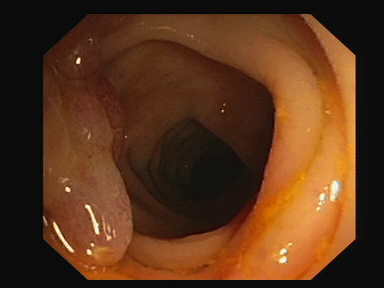

In [29]:
img = Image.open("prepared_dataset/PolypDetection/val/images/10.png")
img

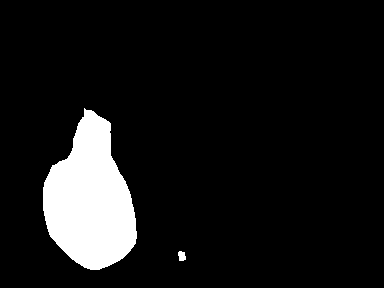

In [28]:
with torch.no_grad():
    logits = model(img_tensor)
    output=logits
    #print("output",output.shape)
    #output=output.unsqueeze(0).cpu()
    output=output[0]
    preds = output.argmax(0)
Image.fromarray(preds.byte().cpu().numpy()*255).resize(img.size)

## Conclusion

| Metric | Pretrained FCN model | Trained FCN model from Scratch |Fine tune pre-trained FCN model |
| ------ | ---------------------| ------------------------------ |--------------------------------|
| Pixel Accuracy | 83.0500| 97.6578 |98.4464|
| Intersection-over-Union | 51.3325| 78.2968 |83.0318|
| Dice Coefficient | 47.7638| 85.3292 |89.1641|



In conclusion, 
- The pretrained FCN model achieved a good performance with an average pixel accuracy of 83.0500, average Intersection-over-Union of 51.3325, and average Dice Coefficient of 47.7638.
- The trained FCN model from scratch outperformed the pretrained model with a pixel accuracy of 97.6578, Intersection-over-Union of 78.2968, and Dice Coefficient of 85.3292.
- Fine-tuning the pretrained FCN model further improved the performance with a pixel accuracy of 98.4464, Intersection-over-Union of 83.0318, and Dice Coefficient of 89.1641.

These results demonstrate the effectiveness of using FCN models for image segmentation tasks.
Fine-tuning the pretrained model is a more efficient approach than training from scratch and can yield significant performance gains.
Overall, the results suggest that transfer learning techniques such as fine-tuning can be used to improve the performance of FCN models for image segmentation tasks.